# Pytorchサンプルコード with Cifar10

これから記載するPytorchのサンプルコードは、cifar10という画像データセットを学習し、<br>
入力画像がどのような画像か？をラベリング（ラベルは一つのみ）するモデルを構築します。

また本チュートリアル作成時のPytorchのバージョンは、v1.5.1となります。

## ベースとなるチュートリアル

本チュートリアルは下記のPytorchのチュートリアルをベースに作成しています。<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


## Cifar10について

Cifar10は画像データセットになっていて、画像サイズは32*32(RGB)となります。<br>
画像の種類は10種類(後述のコードに記載)となっております。<br>

<br>
よって、一枚の画像のデータサイズとしては、32*32*3となります。

## ニューラルネットワークを構築する

今回はCifar10のデータセットを利用して、シンプルなニューラルネットワーク（多層パーセプトロン）を構築してみます。<br>
前述したように、ニューラルネットワークを構築するために以下のステップが必要になります。

1. データセットの作成
2. ニューラルネットワークの定義
3. ニューラルネットワークの学習

上記ステップでどのような実装が必要なのか？を具体的にPytorchを利用して、実装していきます。

## 1. データセットの作成

まずはCifar10のデータセットを作成していきます。<br>
Pytorchや他のメジャーなDNNフレームワークでは、Cifar10などのような有名どころなデータセットは標準で実装されていることが多いです。<br>

In [7]:
# pytorchの関連ライブラリをインポートする
import torch
import torchvision
import torchvision.transforms as transforms

## 2. ニューラルネットワークの定義

データセットの準備が出来たため、次はニューラルネットワーク（モデル）の定義を行います。<br>
今回は以下のような多層パーセプトロンを定義します。

* 入力サイズは、32*32*3 (Cifar10の一枚の画像サイズが32*32*3のため）
* 隠れ層1（FCレイヤー）は、32*32*3 -> 720次元に変換
* 隠れ層2（FCレイヤー）は、720次元 -> 84に変換
* 隠れ層3（FCレイヤー）は、84 -> 10に変換
* 損失関数をクロスエントロピー、最適化関数をSGD（確率的勾配降下法）を設定

最後が10なのは、今回のCifar10だと10種類の画像への分類タスクのため、どの種類である可能性が高いか？をスコアとして出すようなモデルとしています。

In [8]:
# Cifar10のデータセットの作成

## Cifar10のデータセットをロードする際に行う前処理を定義
### ToTensorは、PIL Imageやndarray(numpy)のデータを, channel * height * widthに変換する処理（Pytorchで扱いやすいデータの型にしていると考えれば良い）
### Normalizeは、各列の平均と標準偏差を指定して、正規化を行う処理（下記だと、channel方向ならば、平均0.5, 標準偏差0.5でデータを正規化する）
### ToTensor -> https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

## 学習用データセットの定義
### batch_size=4のため、4枚の画像毎に学習ステップを一回実施
### shuffle=Trueだと、1epochごとにデータをシャッフルする
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

## テストデータセットの定義
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

## 分類ラベルの定義
### 元々cifar10では分類クラスが決まっている（10種類 -> だからcifar10）
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


shape is (3, 36, 138)


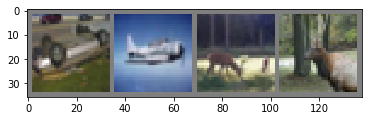

car plane  deer  deer


In [9]:
# 画像を描画してみます
## 平均0.5, 標準偏差0.5に設定しているため、画像描画時は元のデータに戻す処理を加えてます

import matplotlib.pyplot as plt
import numpy as np

# PytorchのTensorから画像を描画するための関数
def imshow(img):
    img = img / 2 + 0.5  # Normalizeしたデータを元に戻している
    npimg = img.numpy()
    print("shape is {}".format(npimg.shape))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # PIL Imageで読み込む際には、Height * Width * Channelにデータの順序を戻す必要があるため、Transposeで配列順序を入れ替えています
    plt.show()


# 学習用のDataLoaderから画像を試しに1バッチ分（= 4枚）取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示を実施
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 3. ニューラルネットワークの学習

モデル構造の定義が出来ましたので、次にデータセットを利用して、モデルを学習していきます。<br>
前述してますが、モデルの学習では、バッチサイズ毎に以下の学習ステップを行なっています。

1. 順伝播処理の実施（入力層にデータを入れて、出力層から結果を出力）
1. 誤差の算出（出力結果を何かしらのデータ（例えば、教師データなど）と比較して、損失関数から誤差を算出）
1. 誤差逆伝播の実施（出力層の誤差情報を、各層に対してフィードバック）
1. パラメーター最適化（各層の誤差情報を元に、パラメーターを最適化する。最適化関数を利用）

In [10]:
# Cifar10の画像から、その画像が何か？（どのラベルに該当するか？）を判定するモデルを構築します
import torch.nn as nn
import torch.nn.functional as F

# TODO : モデルに関する説明の実施
class FCNet(nn.Module):
    def __init__(self, width=32, height=32, channel=3):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(width * height * channel, 720)
        self.fc2 = nn.Linear(720, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 入力画像には、Tensor(Channel, Width, Height)が渡って来るため、FCレイヤーで計算できるように1次元に変換します(= Flatten)
        ## Flattenをやらずに、DataSet作成時に1次元なデータセットに変換する処理を実施してもOKです
        ## transforms.LinearTransformation を利用することになります( https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.LinearTransformation )
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# RGBな画像のため、チャネル数は3となります
net = FCNet()

In [11]:
# 損失関数と最適化手法の設定を行います
## TODO : 損失関数と最適化手法の説明の実施

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 学習したモデルの利用

構築したモデルを利用して、テストデータでの推論処理を試してみましょう。

start training....
[1,  2000] loss: 1.919
[1,  4000] loss: 1.688
[1,  6000] loss: 1.625
[1,  8000] loss: 1.586
[1, 10000] loss: 1.551
[1, 12000] loss: 1.511
1 epoch loss : 1.6405622886526585
[2,  2000] loss: 1.438
[2,  4000] loss: 1.431
[2,  6000] loss: 1.411
[2,  8000] loss: 1.414
[2, 10000] loss: 1.417
[2, 12000] loss: 1.393
2 epoch loss : 1.417758093289733
[3,  2000] loss: 1.299
[3,  4000] loss: 1.309
[3,  6000] loss: 1.302
[3,  8000] loss: 1.319
[3, 10000] loss: 1.307
[3, 12000] loss: 1.319
3 epoch loss : 1.3127131542646886
[4,  2000] loss: 1.217
[4,  4000] loss: 1.221
[4,  6000] loss: 1.225
[4,  8000] loss: 1.249
[4, 10000] loss: 1.231
[4, 12000] loss: 1.244
4 epoch loss : 1.2313325531554222
[5,  2000] loss: 1.140
[5,  4000] loss: 1.140
[5,  6000] loss: 1.173
[5,  8000] loss: 1.173
[5, 10000] loss: 1.160
[5, 12000] loss: 1.176
5 epoch loss : 1.1605915657392145
finish training....


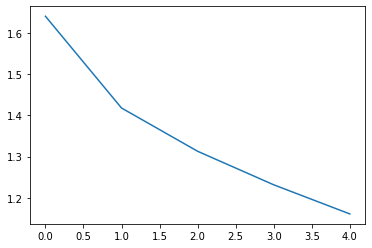

In [12]:
# 学習用のデータセットを用いて、モデルの学習を行います

# 1epochでデータセットに含まれる全データを利用して、一度学習処理をしたことになります。
# 例えば、5epochなら、全データを5回繰り返し利用して、学習したことになります。
print("start training....")
epoch_count = 5
epoch_losses = []
for epoch in range(1, epoch_count+1):
    # 1epochごとに全データを学習します
    ## バッチサイズごとに学習を実施し、損失（ロス）を算出します
    ## 損失結果を利用し、誤差逆伝播を行い、定義した最適化関数に応じた最適化処理（重み調整）を実施します
    train_loss = 0.0
    train_total_loss_in_1epoch = 0
    for i, data in enumerate(trainloader, 0):
        # バッチサイズ分の画像データがdataにラベル情報（cat, trainなど）と一緒に含まれています
        inputs, labels = data
        
        # 勾配情報（誤差逆伝播した際の差分情報）をバッチごとに初期化します
        ## 勾配情報は累積されるため、バッチサイズ単位で（勾配情報を利用して）最適化処理を行います。
        ## そのため、バッチサイズでの最適化処理が終われば、次のバッチサイズのデータで学習する前に勾配のリセットが必要となります。
        optimizer.zero_grad()

        # モデルの順伝播、誤差逆伝播、最適化処理を実施
        ## 1. 順伝播の実施
        outputs = net(inputs)
        ## 2. バッチサイズ分の損失を算出
        loss = criterion(outputs, labels)
        ## 3. 誤差逆伝播の実施
        loss.backward()
        ## 4. 最適化処理の実施
        optimizer.step()

        # 学習状況を可視化する
        ## ロスの状況を可視化する。今回の場合だと、2000バッチ（=> 4 * 2000 = 8000データごと）ごとにロスを表示する
        train_loss += loss.item()
        ## 1epchごとのロスを算出するために、1バッチごとのロスを蓄積させる
        train_total_loss_in_1epoch += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch, i + 1, train_loss / 2000))
            train_loss = 0
    epoch_losses.append(train_total_loss_in_1epoch/len(trainloader))
    print("{} epoch loss : {}".format(epoch, train_total_loss_in_1epoch/len(trainloader)))
plt.plot(epoch_losses)

# 学習状況を保存します
import os

save_folder = "result"
os.makedirs(save_folder, exist_ok=True)
plt.savefig(os.path.join(save_folder, "train_result_epoch_{}.png".format(epoch_count)))
print("finish training....")

In [13]:
# 学習済みとなったモデルを保存します
model_foder = "model"
os.makedirs(model_foder, exist_ok=True)
saved_model_path = os.path.join(model_foder, "cifar_fcnet_epoch{}.pth".format(epoch_count))
torch.save(net.state_dict(), saved_model_path)

shape is (3, 36, 138)


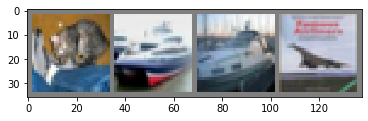

GroundTruth:    cat  ship  ship plane


In [14]:
# 作成したモデルを利用して、テストデータでも検証してみます
## まずはテストデータの中身を学習データと同様に表示してみます(1バッチ分の表示を行います)

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
## 学習済みモデルを復元しましょう

## 学習済みモデルのロードを行います
net = FCNet()
### OrderdDict形式（順序つき辞書形式）で,pathからパラメーター情報を取得する
param_dict = torch.load(saved_model_path)
### dict情報から、学習済みのモデルを復元する
net.load_state_dict(param_dict)

<All keys matched successfully>

In [16]:
## 次に1バッチ分のデータ（先ほど表示した画像）に対して、作成したモデルでの予測を試します
outputs = net(images)

### もっとも確度が高い予測ラベルのみを取得します
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship horse


In [17]:
### 試しに分類時のスコアと、他にどのような候補があがったかをみてみましょう
scores, predicted = torch.topk(outputs, k=3, dim=1)
for i in range(len(outputs)):
    print("## {} ##".format(i))
    for score, candidate in zip(scores[i], predicted[i]):
        print("predicted candidate/score : {}:{}".format(classes[candidate], score))

## 0 ##
predicted candidate/score : cat:4.314324855804443
predicted candidate/score : dog:2.909773826599121
predicted candidate/score : car:1.6356018781661987
## 1 ##
predicted candidate/score : car:5.515995979309082
predicted candidate/score : ship:4.139929294586182
predicted candidate/score : truck:3.467362880706787
## 2 ##
predicted candidate/score : ship:3.894742965698242
predicted candidate/score : car:2.7930727005004883
predicted candidate/score : truck:2.336524486541748
## 3 ##
predicted candidate/score : horse:2.152127742767334
predicted candidate/score : car:1.5618911981582642
predicted candidate/score : plane:1.2614152431488037


In [18]:
## 作成したモデルを利用して、テストデータに対して、精度を検証してみます
### 今回の精度検証では、TOP-1スコアでの精度検証となります。（画像分類タスクでは、TOP-1、TOP-5などのスコアがあったりします）
### TOP5の場合は、予測した結果、上位5個の分類結果内に正解ラベルがあれば、正しい分類とみなします。
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy Top1 of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy Top1 of the network on the 10000 test images: 52 %


In [19]:
### TOP3のケースでも結果を算出してみましょう
correct = 0
total = 0
top_k = 3
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.topk(outputs, k=top_k, dim=1)
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted[i]:
                correct += 1
print('Accuracy Top3 of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy Top3 of the network on the 10000 test images: 82 %


In [20]:
### 単純に全体の精度を出すだけでなく、どのラベルの精度が高いか？低いか？を検証してみましょう
class_correct = list(0. for i in range(len(classes)))
class_total   = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        # squeeze（各次元で1要素しかない場合に、該当する次元を削除する）を実施して、Tensorの構造をベクトルへと修正
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# 各ラベルの正答率を表示します
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 67 %
Accuracy of  bird : 29 %
Accuracy of   cat : 32 %
Accuracy of  deer : 48 %
Accuracy of   dog : 55 %
Accuracy of  frog : 58 %
Accuracy of horse : 53 %
Accuracy of  ship : 70 %
Accuracy of truck : 54 %
